                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.706e-05      0.074      0.000      1.000      -0.146       0.146
ar.L1.y       -0.8709      0.069    -12.639      0.000      -1.006      -0.736
ar.L2.y       -0.7429      0.090     -8.240      0.000      -0.920      -0.566
ar.L3.y       -0.6160      0.101     -6.124      0.000      -0.813      -0.419
ar.L4.y       -0.4904      0.103     -4.739      0.000      -0.693      -0.288
ar.L5.y       -0.3660      0.100     -3.666      0.000      -0.562      -0.170
ar.L6.y       -0.2427      0.089     -2.727      0.006      -0.417      -0.068
ar.L7.y       -0.1207      0.068     -1.781      0.075      -0.254       0.012


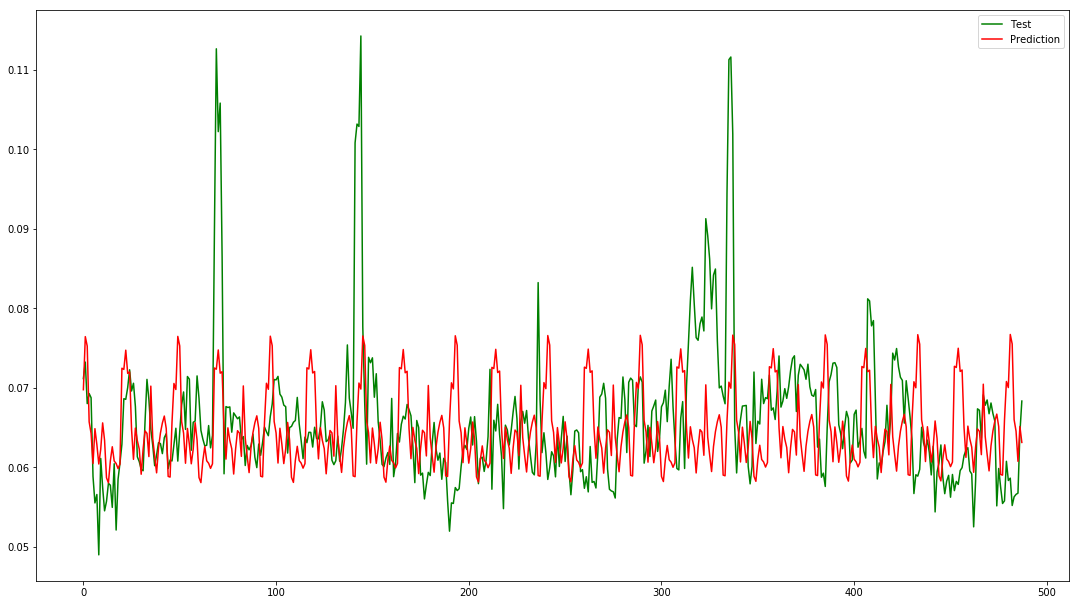

The Mean Squared Error of our forecasts is 0.0001
['i', 'actual', 'prediction', 'actual_64', 'prediction_64', 'actual_128', 'prediction_128', 'actual_256', 'prediction_256', 'actual_512', 'prediction_512']


In [63]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import csv;

def isSeriesStationary(series):
    pValue = adfuller(series)[1]
    if pValue > 0.05:
        return False
    else:
        return True
    
def isSeriesStationaryAvg(series, delta = 2):
    split = int(len(series)/2)
    split1, split2 = series[:split], series[split:]
    avg1, avg2 = split1.mean(), split2.mean()
    var1, var2 = split1.var(), split2.var()
    if abs(avg1 - avg2) > delta or abs(var1 - var2) > delta**2:
        return False
    else:
        return True
    
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def describeSeries(data, label):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(data, label = "Series")
    plt.plot(pd.rolling_mean(data, window = 2), '--', label = "Rolling mean")
    plt.plot(pd.rolling_std(data, 2), ":", label = "Rolling Std")
    plt.legend()
    plt.clf()
    
def splitTrainTest(series, testSplit):
    totalData = len(series)
    trainSplit = int(totalData * (1 - testSplit))
    trainSet = series[:trainSplit]
    testSet = series[trainSplit:]
    return trainSet, testSet

temperatureData = pd.read_csv("/Users/hasan/workplace/hypervisor/spot-memory/cluster_trace/cpu_mem.csv", dtype={'total mem': float})
temperatureData.head()


trainSet, testSet = splitTrainTest(temperatureData["mem"].values, 0.7)

differencedTrainSet = difference(trainSet, 1)
model = ARIMA(differencedTrainSet, order=(7,0,0))
"""Fit model with non constant trend and no displacement"""
model_fit = model.fit(disp = 0)
forecast = model_fit.predict(len(differencedTrainSet), len(differencedTrainSet) + len(testSet))

print(model_fit.summary().tables[1])

yPrediction = []
history = list(trainSet)
for f in forecast:
    yPredict = inverse_difference(history, f, 48)
    yPrediction.append(yPredict)
    history.append(yPredict)
    

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(testSet, color='green', label = "Test")
plt.plot(yPrediction[:-1], color='red', label = "Prediction")
plt.legend()
plt.show()

yPrediction = yPrediction[:-1]

# Compute the mean square error
mse = ((yPrediction - testSet) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

fields = ["i","actual", "prediction"]
size = [64, 128, 256, 512]
for s in size:
    fields.append("actual_"+str(s))
    fields.append("prediction_"+str(s));

print(fields)
# with open('./prediction.csv', mode='w') as csv_file:
#         writer = csv.DictWriter(csv_file, fieldnames=fields);
#         writer.writeheader();
#         for idx in range(0, len(testSet)):
#             row = {"i":idx,"actual":testSet[idx], "prediction": max (0,yPrediction[idx])}
#             for s in size:
#                 row["actual_"+str(s)] = float(row["actual"] * (int) (s));
#                 row["prediction_"+str(s)] = float(row["prediction"] * (int) (s));
#             writer.writerow(row);
